In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [4]:
from ucimlrepo import fetch_ucirepo

# Fetch the dataset from UCI Machine Learning Repository
dataset = fetch_ucirepo(id=45)

# create a DataFrame from the dataset
df = dataset.data.original
target = dataset.data.targets


df['target'] = target

In [5]:
dataset.metadata

{'uci_id': 45,
 'name': 'Heart Disease',
 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease',
 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv',
 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 303,
 'num_features': 13,
 'feature_types': ['Categorical', 'Integer', 'Real'],
 'demographics': ['Age', 'Sex'],
 'target_col': ['num'],
 'index_col': None,
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1989,
 'last_updated': 'Fri Nov 03 2023',
 'dataset_doi': '10.24432/C52P4X',
 'creators': ['Andras Janosi',
  'William Steinbrunn',
  'Matthias Pfisterer',
  'Robert Detrano'],
 'intro_paper': {'ID': 231,
  'type': 'NATIVE',
  'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.',
  'authors': 'R. Detr

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,0


In [7]:
df.target.nunique(), df.target.unique(), df.target.value_counts()

(5,
 array([0, 2, 1, 3, 4]),
 target
 0    164
 1     55
 2     36
 3     35
 4     13
 Name: count, dtype: int64)

The dataset is of multi classification.
0 = no disease and
1, 2, 3, 4 = varying levels of disease (the higher the number, the more severe the condition)

In [8]:
# let's prepare out binary classification dataset
df['binary_target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(df.binary_target.unique(), df.binary_target.value_counts())

[0 1] binary_target
0    164
1    139
Name: count, dtype: int64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            303 non-null    int64  
 1   sex            303 non-null    int64  
 2   cp             303 non-null    int64  
 3   trestbps       303 non-null    int64  
 4   chol           303 non-null    int64  
 5   fbs            303 non-null    int64  
 6   restecg        303 non-null    int64  
 7   thalach        303 non-null    int64  
 8   exang          303 non-null    int64  
 9   oldpeak        303 non-null    float64
 10  slope          303 non-null    int64  
 11  ca             299 non-null    float64
 12  thal           301 non-null    float64
 13  num            303 non-null    int64  
 14  target         303 non-null    int64  
 15  binary_target  303 non-null    int64  
dtypes: float64(3), int64(13)
memory usage: 38.0 KB


In [10]:
df.cp.nunique(), df.cp.unique(), df.cp.value_counts(), df.shape, df.isna().sum()

(4,
 array([1, 4, 3, 2]),
 cp
 4    144
 3     86
 2     50
 1     23
 Name: count, dtype: int64,
 (303, 16),
 age              0
 sex              0
 cp               0
 trestbps         0
 chol             0
 fbs              0
 restecg          0
 thalach          0
 exang            0
 oldpeak          0
 slope            0
 ca               4
 thal             2
 num              0
 target           0
 binary_target    0
 dtype: int64)

In [11]:
df = df.dropna()

In [12]:
df.isna().sum()

age              0
sex              0
cp               0
trestbps         0
chol             0
fbs              0
restecg          0
thalach          0
exang            0
oldpeak          0
slope            0
ca               0
thal             0
num              0
target           0
binary_target    0
dtype: int64

In [22]:
# list of categorical and numerical features
cat_cols= ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak','ca']

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

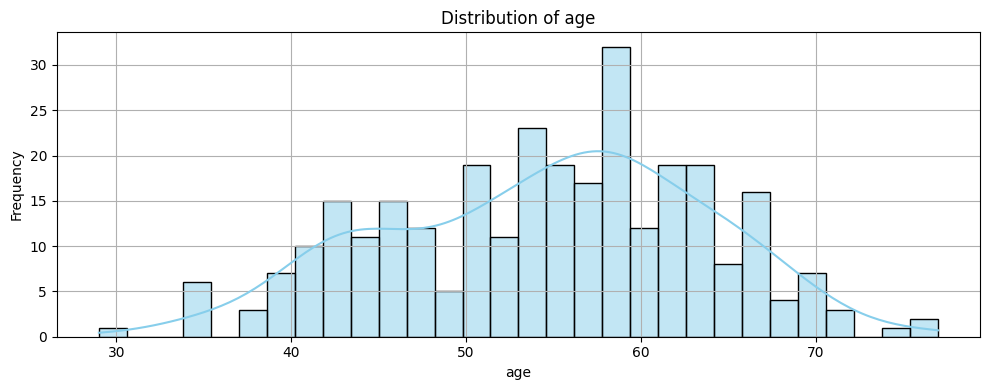

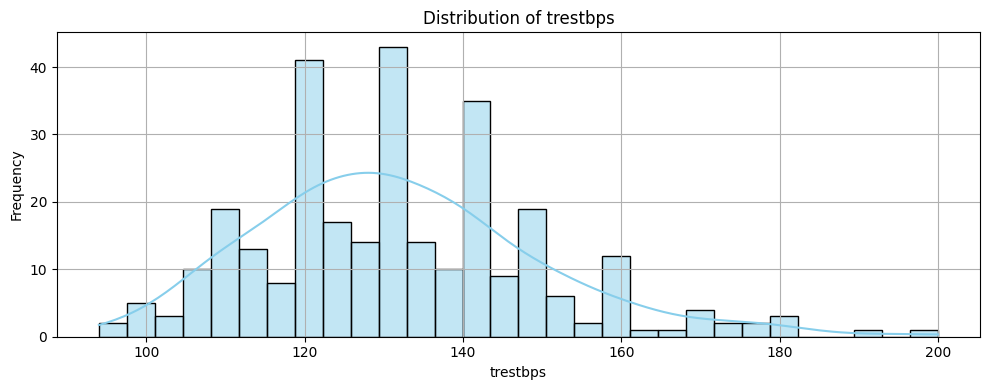

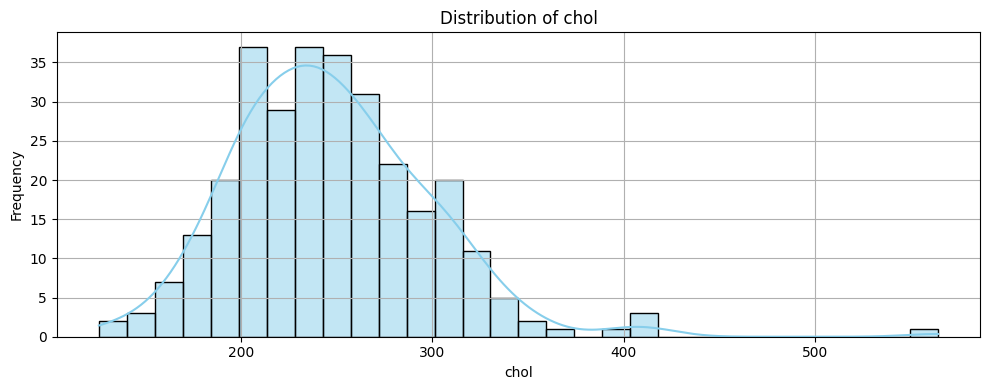

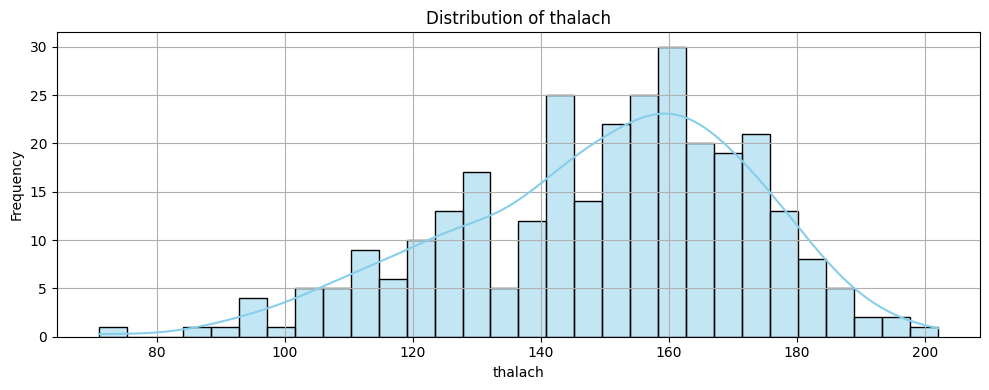

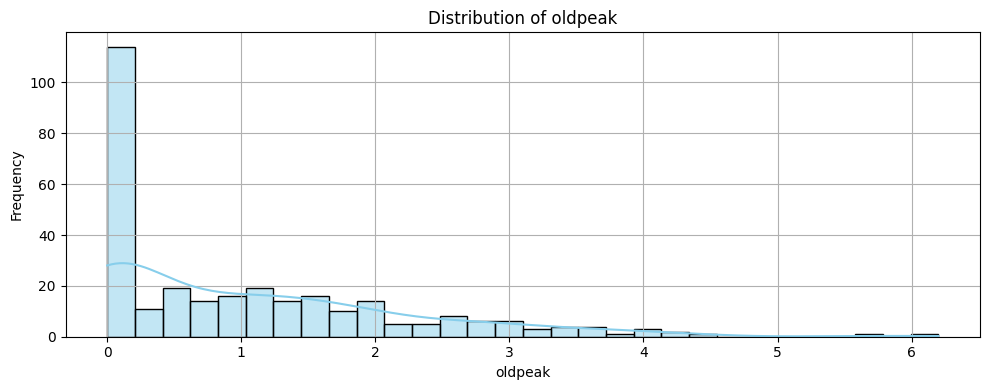

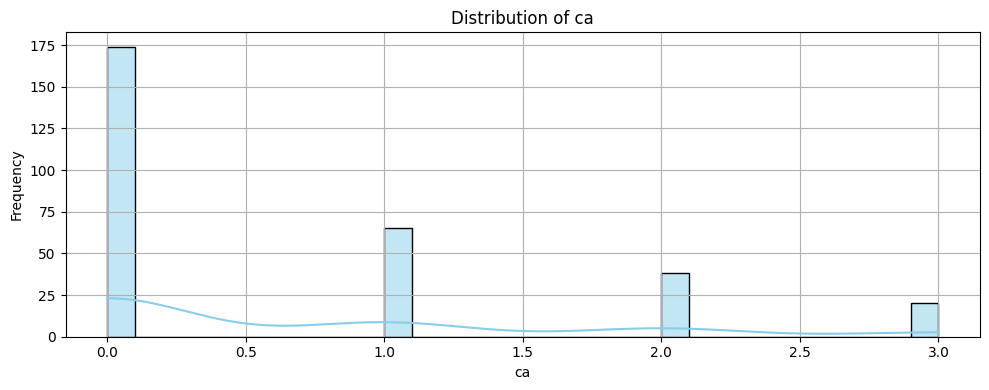

In [52]:
for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    plt.title(f"Distribution of {col}")
    sns.histplot(df[col], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
def histogram_plot(df, col):
    plt.figure(figsize=(10, 4))
    plt.title(f"Distribution of {col}")
    sns.histplot(df[col], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

(297, 16) age              0
sex              0
cp               0
trestbps         0
chol             0
fbs              0
restecg          0
thalach          0
exang            0
oldpeak          0
slope            0
ca               0
thal             0
num              0
target           0
binary_target    0
dtype: int64
Scaling age...


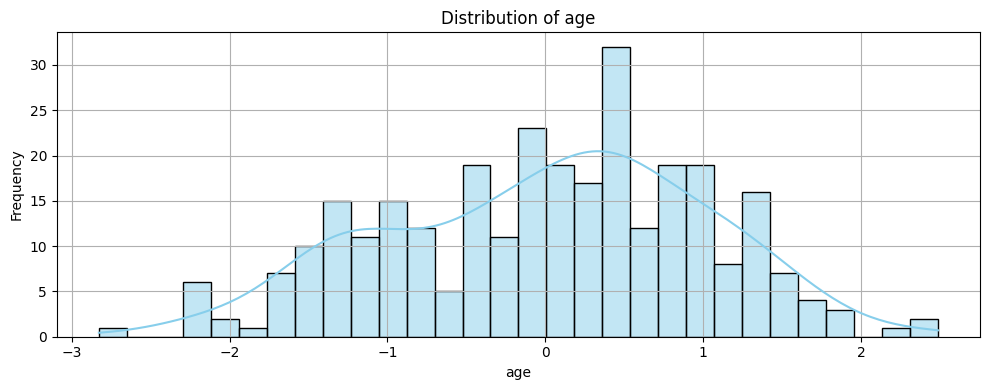

Scaling trestbps...


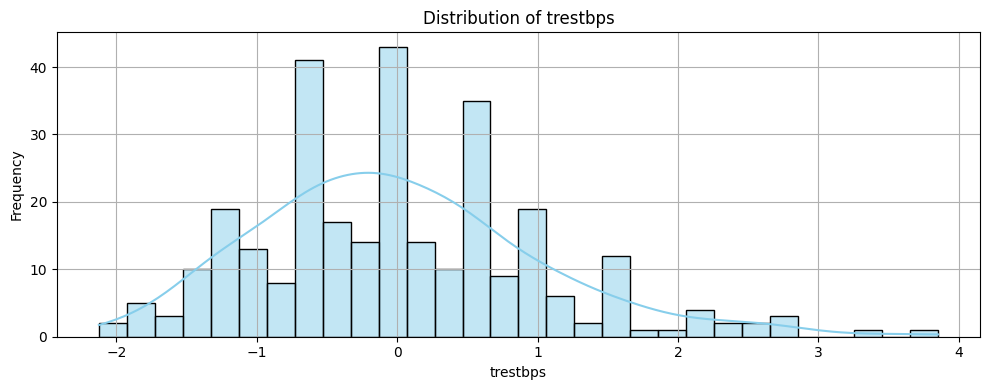

Scaling chol...


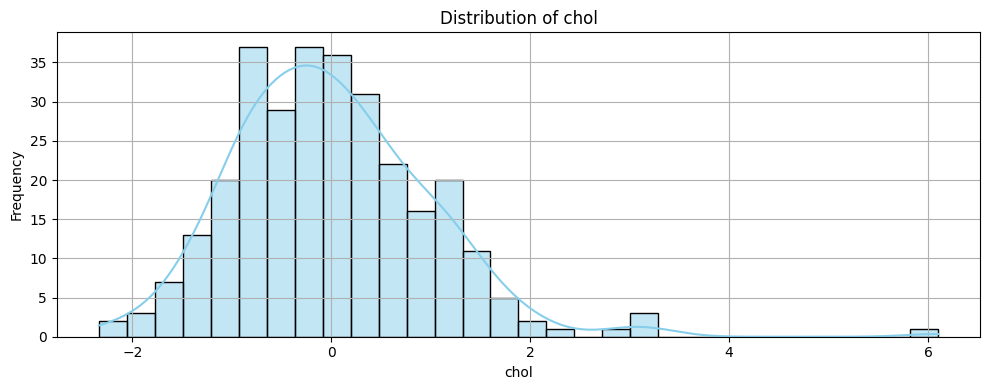

Scaling thalach...


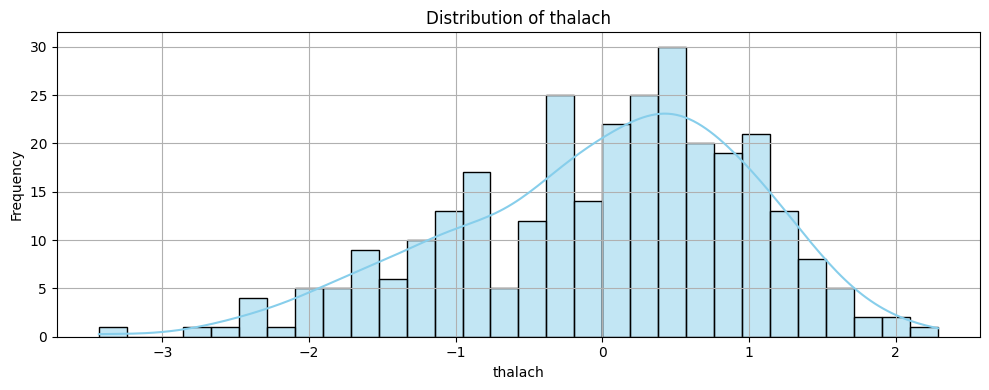

Scaling oldpeak...


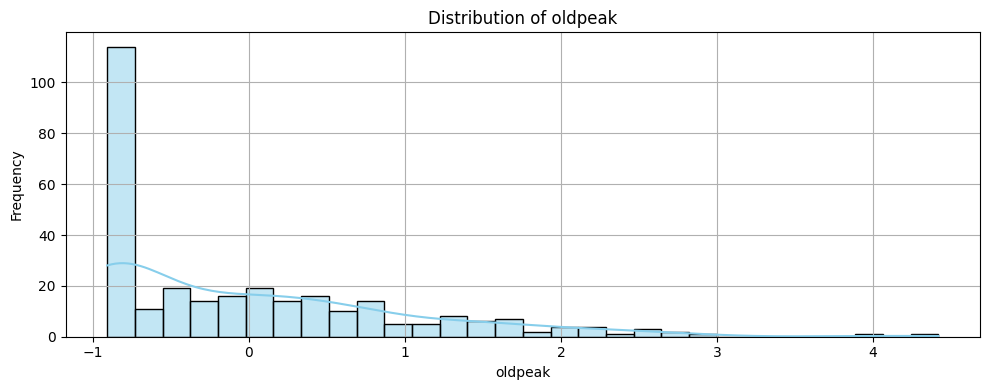

Scaling ca...


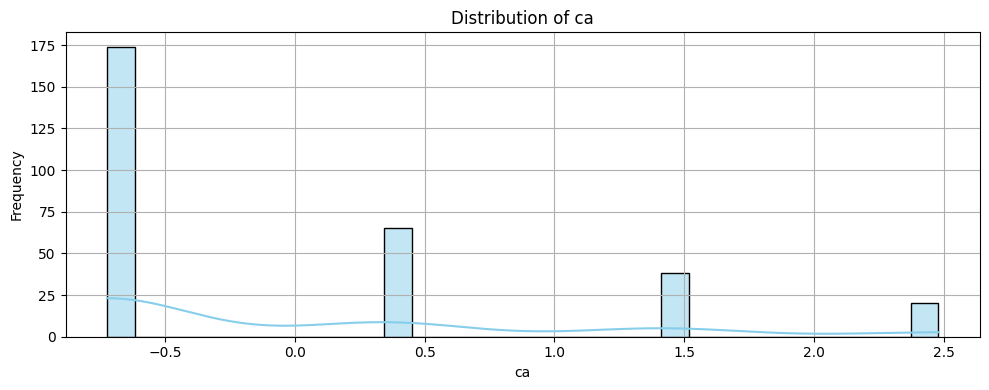

In [40]:
df_scaled = df.copy()
print(df_scaled.shape, df_scaled.isna().sum())

for col in numeric_cols:
    print(f"Scaling {col}...")
    df_scaled[col] = StandardScaler().fit_transform(df[[col]])
    histogram_plot(df_scaled, col)


In [37]:
df_scaled.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target,binary_target
count,2.970000e+02,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,-1.226105e-16,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128,0.946128,0.461279
std,1.001688e+00,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551,1.234551,0.499340
min,-2.827176e+00,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,-7.241238e-01,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000
50%,1.613719e-01,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000
75%,7.148067e-01,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000,2.000000,1.000000
max,2.485798e+00,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,4.000000,1.000000


In [38]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            297 non-null    float64
 1   sex            297 non-null    int64  
 2   cp             297 non-null    int64  
 3   trestbps       297 non-null    int64  
 4   chol           297 non-null    int64  
 5   fbs            297 non-null    int64  
 6   restecg        297 non-null    int64  
 7   thalach        297 non-null    int64  
 8   exang          297 non-null    int64  
 9   oldpeak        297 non-null    float64
 10  slope          297 non-null    int64  
 11  ca             297 non-null    float64
 12  thal           297 non-null    float64
 13  num            297 non-null    int64  
 14  target         297 non-null    int64  
 15  binary_target  297 non-null    int64  
dtypes: float64(4), int64(12)
memory usage: 39.4 KB


In [39]:
df_scaled.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target,binary_target
age,1.000000,-0.092399,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.126586,0.222156,0.222156,0.227075
sex,-0.092399,1.000000,0.008908,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.383652,0.226797,0.226797,0.278467
cp,0.110471,0.008908,1.000000,-0.036980,0.072088,-0.057663,0.063905,-0.339308,0.377525,0.203244,0.151079,0.235644,0.268500,0.404248,0.404248,0.408945
trestbps,0.290476,-0.066340,-0.036980,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.138183,0.159620,0.159620,0.153490
chol,0.202644,-0.198089,0.072088,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.010859,0.066448,0.066448,0.080285
fbs,0.132062,0.038850,-0.057663,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.062209,0.049040,0.049040,0.003167
restecg,0.149917,0.033897,0.063905,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.018795,0.184136,0.184136,0.166343
thalach,-0.394563,-0.060496,-0.339308,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.274831,-0.420639,-0.420639,-0.423817
exang,0.096489,0.143581,0.377525,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.326927,0.391613,0.391613,0.421355
oldpeak,0.197123,0.106567,0.203244,0.191243,0.038596,0.008311,0.113726,-0.347640,0.289310,1.000000,0.579037,0.294452,0.344976,0.501461,0.501461,0.424052


In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled.drop(columns=['target', 'binary_target', 'num']),
    df_scaled['binary_target'],
    test_size=0.2,
    random_state=42,
)
print("Data split into train and test sets")
print(f"X_train shape: {X_train.shape[0]}, X_test shape: {X_test.shape[0]}")

Data split into train and test sets
X_train shape: 237, X_test shape: 60


In [54]:
log_reg = LogisticRegression()

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

# Best results
print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV Accuracy):", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score (CV Accuracy): 0.8187056737588654

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        36
           1       0.77      0.83      0.80        24

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



In [56]:
confusion_matrix(y_test, y_pred)

array([[30,  6],
       [ 4, 20]])